In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


# Importing the packages and loading the datasets

In [2]:
!pip install twython
!pip install nltk

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm.notebook import tqdm

#1st approach
from nltk.sentiment import SentimentIntensityAnalyzer

#2nd Approach
from transformers import AutoTokenizer,AutoModelForSequenceClassification
from scipy.special import softmax

In [3]:
train_set = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", header=0, names=["TweetID","Entity","Sentiment","Content"])
valid_set = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv",header=0, names=["TweetID","Entity","Sentiment","Content"])
df = pd.concat([train_set,valid_set])
df

,TweetID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [4]:
df.isnull().sum()

TweetID        0
Entity         0
Sentiment      0
Content      686
dtype: int64

In [5]:
df.dropna(inplace=True)
df.isnull().sum()

TweetID      0
Entity       0
Sentiment    0
Content      0
dtype: int64

In [6]:
df.duplicated().sum()

2856

In [7]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [8]:
df

,TweetID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
987,7516,LeagueOfLegends,Neutral,♥️ Suikoden 2\n1️⃣ Alex Kidd in Miracle World\...
988,5708,HomeDepot,Positive,Thank you to Matching funds Home Depot RW paym...
990,2165,CallOfDuty,Neutral,Late night stream with the boys! Come watch so...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...


In [9]:
df.describe()

,TweetID
count,72138.000000
mean,6435.525521
std,3743.594729
min,1.000000
25%,3195.000000
50%,6432.000000
75%,9607.000000
max,13200.000000


In [10]:
df.describe(include = 'object')

,Entity,Sentiment,Content
count,72138,72138,72138
unique,32,4,69973
top,TomClancysRainbowSix,Negative,"At the same time, despite the fact that there ..."
freq,2349,21790,172


# Data Visualization

<Axes: ylabel='count'>

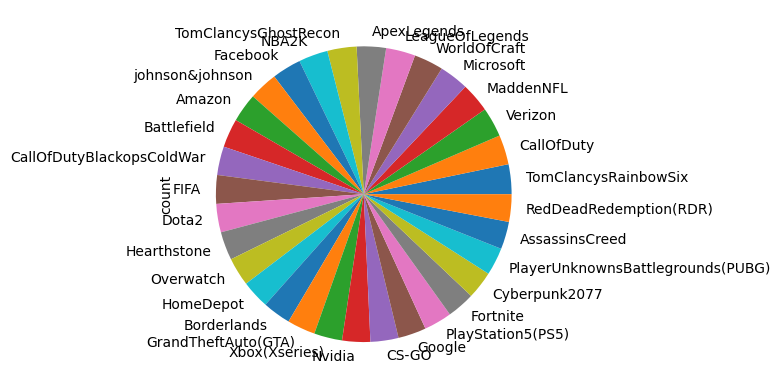

In [11]:
df['Entity'].value_counts().plot(kind = 'pie')

<Axes: xlabel='Entity'>

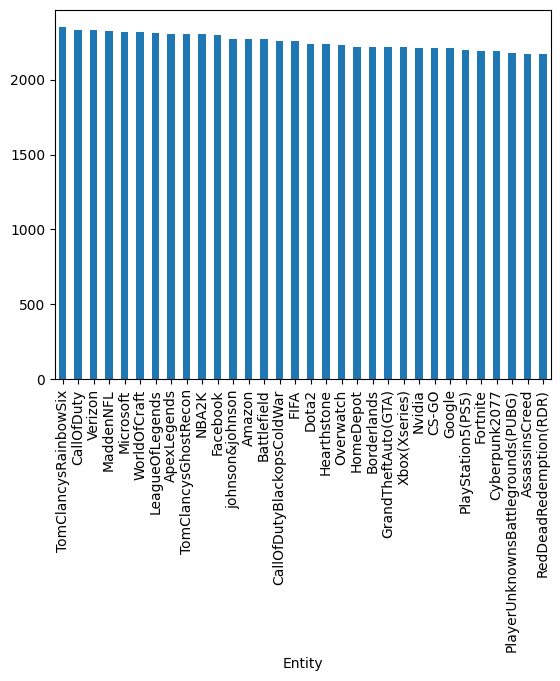

In [12]:
df['Entity'].value_counts().plot(kind = 'bar')

Text(120.7222222222222, 0.5, 'Entity')

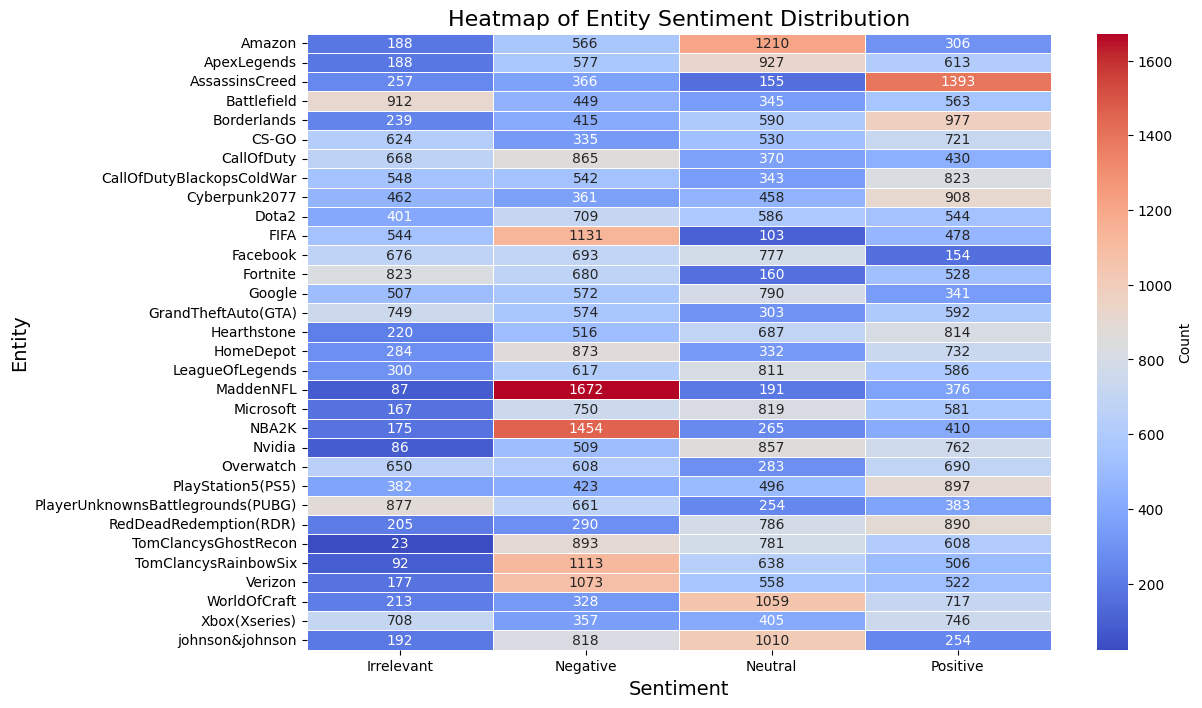

In [13]:
crosstab = pd.crosstab(index=df['Entity'], columns=df['Sentiment'])
plt.figure(figsize=(12, 8))
sns.heatmap(crosstab, cmap='coolwarm', annot=True, fmt='d', linewidths=.5, cbar_kws={'label': 'Count'})
plt.title('Heatmap of Entity Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Entity', fontsize=14)

### One Hot Encoding the Categorical Variables

In [14]:
df2 = pd.get_dummies(df,columns=["Entity","Sentiment"], drop_first=True)
df2

,TweetID,Content,Entity_ApexLegends,Entity_AssassinsCreed,Entity_Battlefield,Entity_Borderlands,Entity_CS-GO,Entity_CallOfDuty,Entity_CallOfDutyBlackopsColdWar,Entity_Cyberpunk2077,...,Entity_RedDeadRedemption(RDR),Entity_TomClancysGhostRecon,Entity_TomClancysRainbowSix,Entity_Verizon,Entity_WorldOfCraft,Entity_Xbox(Xseries),Entity_johnson&johnson,Sentiment_Negative,Sentiment_Neutral,Sentiment_Positive
0,2401,I am coming to the borders and I will kill you...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,2401,im getting on borderlands and i will kill you ...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,2401,im coming on borderlands and i will murder you...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,2401,im getting on borderlands 2 and i will murder ...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,2401,im getting into borderlands and i can murder y...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,7516,♥️ Suikoden 2\n1️⃣ Alex Kidd in Miracle World\...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
988,5708,Thank you to Matching funds Home Depot RW paym...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
990,2165,Late night stream with the boys! Come watch so...,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
994,4891,⭐️ Toronto is the arts and culture capital of ...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<Axes: >

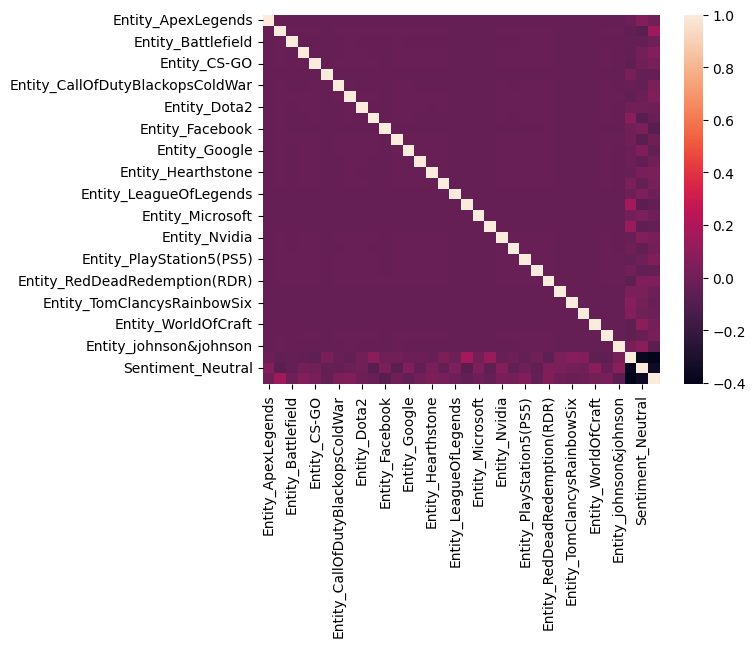

In [15]:
corr = df2.drop(columns=["TweetID","Content"]).corr()
sns.heatmap(corr)

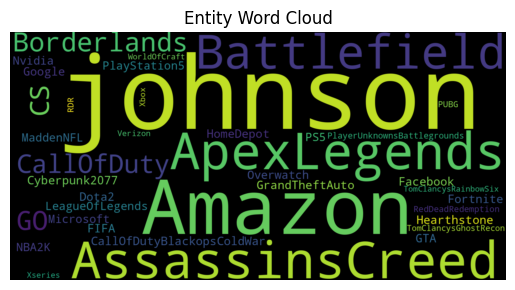

In [16]:
entity_list = ' '.join(crosstab.index)
plt.axis('off')
wc = WordCloud(width=2000, height=1000).generate(entity_list)
plt.title("Entity Word Cloud")
plt.imshow(wc, interpolation='bilinear')

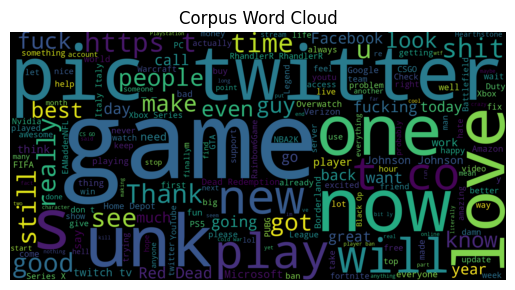

In [17]:
corpus = ' '.join(df['Content'])
plt.axis('off')
plt.title("Corpus Word Cloud")
wc2 = WordCloud(width=2000, height=1000).generate(corpus)
plt.imshow(wc2, interpolation='bilinear')

# Data Pre-Processing

In [18]:
#Making sure the text column is of string type
df['Content'] = df['Content'].astype(str)

 # Using RoBERTa: A Robustly Optimized BERT Pretraining Approach

In [19]:
#A sample of the entire dataset as the entire set is too large
import random
random.seed(42)
sampled_df = df.sample(n=2000, random_state=random.randint(0, 10000))
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 71653 to 31326
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TweetID    2000 non-null   int64 
 1   Entity     2000 non-null   object
 2   Sentiment  2000 non-null   object
 3   Content    2000 non-null   object
dtypes: int64(1), object(3)
memory usage: 78.1+ KB


In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
def polarity_scores_roberta(ex):
    encoded_text = tokenizer(ex, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [23]:
res = {}
sampled_df.info()
for i,row in tqdm(sampled_df.iterrows(), total=len(sampled_df)):
    try: 
        text = row['Content']
        id = row['TweetID']
        roberta_results = polarity_scores_roberta(text)
        res[id] = {**roberta_results}
    except RuntimeError:
        print(f"Broke for id {id}")

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 71653 to 31326
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TweetID    2000 non-null   int64 
 1   Entity     2000 non-null   object
 2   Sentiment  2000 non-null   object
 3   Content    2000 non-null   object
dtypes: int64(1), object(3)
memory usage: 78.1+ KB


  0%|          | 0/2000 [00:00<?, ?it/s]

In [24]:
results_df = pd.DataFrame(res).transpose()
results_df = results_df.reset_index().rename(columns={'index':'TweetID'})
results_df = results_df.merge(sampled_df)

In [25]:
results_df['Roberta_Sentiment'] = results_df[['roberta_neg', 'roberta_neu', 'roberta_pos']].apply(
    lambda x: 'Positive' if x['roberta_pos'] > max(x['roberta_neg'], x['roberta_neu']) 
              else 'Negative' if x['roberta_neg'] > max(x['roberta_pos'], x['roberta_neu']) 
              else 'Neutral', axis=1)
results_df.head()
results_df["Roberta_Sentiment"].value_counts(), results_df["Sentiment"].value_counts()

(Roberta_Sentiment
 Negative    886
 Positive    696
 Neutral     418
 Name: count, dtype: int64,
 Sentiment
 Negative      625
 Positive      534
 Neutral       502
 Irrelevant    339
 Name: count, dtype: int64)

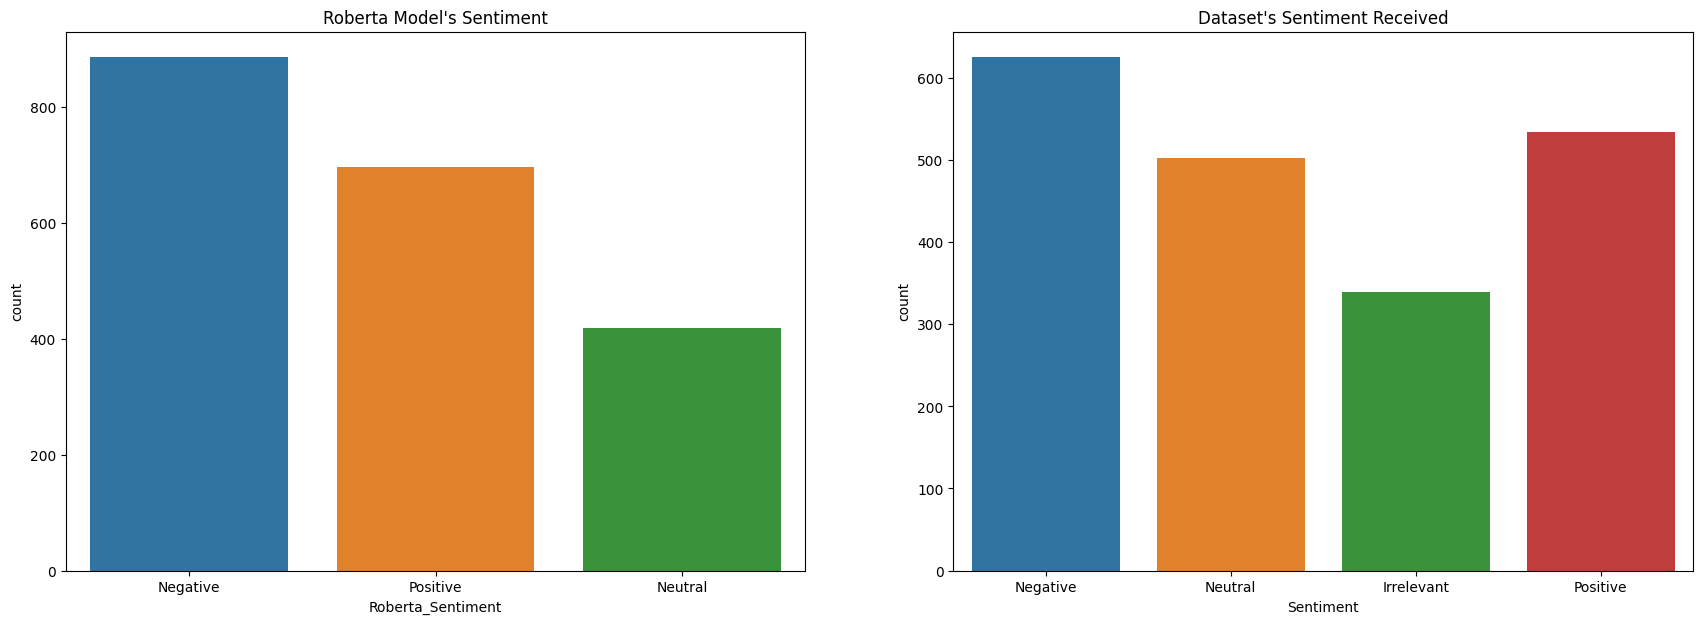

In [26]:
fig, axs = plt.subplots(1,2, figsize=(21,7))
sns.countplot(data=results_df, x='Roberta_Sentiment', ax=axs[0])
sns.countplot(data=results_df, x='Sentiment',ax=axs[1])
axs[0].set_title("Roberta Model's Sentiment")
axs[1].set_title("Dataset's Sentiment Received")
plt.show()

<Figure size 1500x800 with 0 Axes>

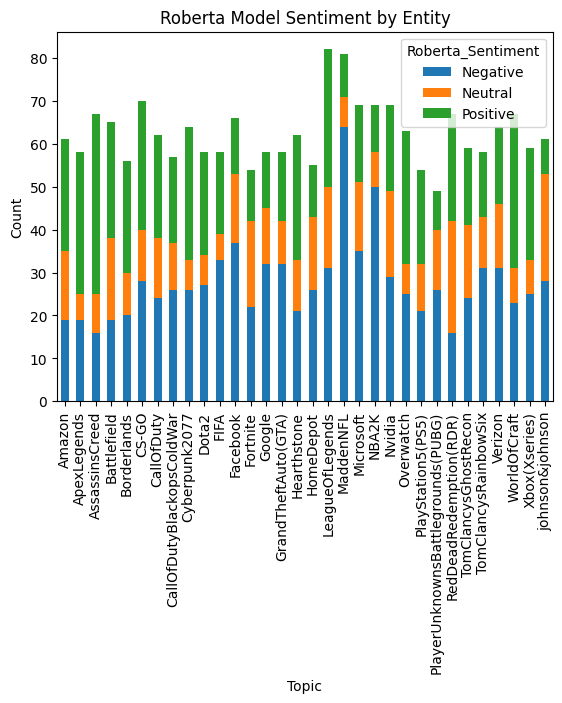

In [27]:
plt.figure(figsize=(15,8))
sentiment_by_topic = results_df.groupby(['Entity','Roberta_Sentiment']).size().unstack(fill_value=0)
sentiment_by_topic.plot(kind='bar', stacked=True)
plt.title('Roberta Model Sentiment by Entity')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()